# Data Wrangling Project

## Table of Contents

* <a href="#introduction">1. Introduction</a>
* <a href="#data_wrangling">2. Data Wrangling</a>
    - <a href="#data_wrangling_gather">2.1 Gathering</a>
    - <a href="#data_wrangling_assess">2.2 Assessment</a>
    - <a href="#data_wrangling_clean">2.3 Cleaning</a>
* <a href="#store_clean_data">3. Storing Cleaned Data</a>
* <a href="#visualizing_data">4. Visualizing Data</a>

<a id="introduction"></a>
###  1.0 Introduction

The goal of this project is to wrangle **@WeRateDogs** Twitter Data to aid trustworthy analysis on the twitter data. 

In this project, all the steps *(Gather,Assess,Clean)*  in the Data Wrangling process are handled. Initially, We have been provided with twitter archive data. This data needs to be asssessed further and need to gather aditional data if needed. All these data need to be cleaned, so that meaningful insights can be derived from the cleaned data.

<a id="data_wrangling"></a>
### 2.0 Data Wrangling

Data Wrangling is one of the key steps in Data Analysis, as it takes 80% or more part of Data Analyst. Real world data is often dirty and unstructured which make data analysis harder. Fortunately, latest software advancements like Python, and libraries  like Pandas, Numpy, etc., makes data analyst's life easier for making the data wrangling process faster, smoother. 

At a high level, the data wrangling comes in 3 different steps, as mentioned below:

* Gather
* Assess
* Clean

Lets dive deeper into each of the steps for the **@WeRateDogs** data to get meaningful insights.

<a id='data_wrangling_gather'></a>
### 2.1 Gathering

In this project, initially we have provided with Twitter Archived Data (*twitter-archive-enhanced.csv*). This archived data contains only tweets which has ratings.

In [1]:
''' Initial all libraries  '''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tweepy
import os as os
import requests
import re
from pandas.io.json import json_normalize
import sqlite3
import seaborn as sns

%matplotlib inline

#### Parse the given twitter archive enhanced data

In [2]:
''' Read the Twitter Archived Data '''
df_tweet_archive = pd.read_csv('./data/provided_data/twitter-archive-enhanced.csv')
df_tweet_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


Twitter Archive Enhanced Field Details:

* `tweet_id`: ID of each tweet
* `in_reply_to_status_id`: If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
* `in_reply_to_user_id`:If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID. This will not necessarily always be the user directly mentioned in the Tweet.
* `timestamp`: Tweet Created Time
* `source`: Source of the Tweet. i.e IPhone, Vine, etc.,
* `text`: Original Text of the Tweet
* `retweeted_status_id`: Retweet Status ID
* `retweeted_status_user_id` : Retweet User ID
* `retweeted_status_timestamp`: Retweet Timestamp
* `expanded_urls`: Tweet URL
* `rating_numerator`: Dog Rating Numerator.
* `rating_denominator`: Dog Rating Denominator. Its always 10.
* `name`: Name of the dog
* `doggo`: Stage of the dog
* `floofer`: Stage of the dog
* `pupper`: Stage of the dog
* `puppo`: Stage of the dog

#### Get additional details on the tweets via Twitter API Call

The above data missing some key information like retweet count, favorite count for each of the tweet. These additional data can be gathered using Twitter API. In this project, 'tweepy' library is used to get the tweet details.

Even though, we can get each individual tweet status by using `get_status` API call, it requires 2356 API calls. It seems, we can get tweets in bulk using `statuses_lookup` API call. `statuses_lookup` API call can upto 100 tweets. Also, we have to make sure the tweet_mode is set to  `extended`, so that tweets are not truncated.

In [3]:
''' This function initialize Twitter API Secret needed for further API calls'''
def initialize_twitter_secrets():
    with open('twitter_secrets.txt', 'r') as content_file:
        twitter_secrets = json.loads( content_file.read())
        return twitter_secrets

In [4]:
''' This function authenticates the application with Twitter and returns API object which can be used for further API Calls'''
def get_twitter_api_handler(twitter_secrets={}):
    auth = tweepy.OAuthHandler(twitter_secrets['consumer_api_key'], twitter_secrets['consumer_api_secret'])
    auth.set_access_token(twitter_secrets['access_token'],twitter_secrets['access_token_secret'])
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    return api

In [5]:
''' The below function get all tweet details for given list and store them in a file in JSON format '''
def get_tweet_details_for_given_list(tweet_list=None, tweet_api = None, split_size=100, file_name=None):
    try:
        # Check for Max Split Size
        if split_size > 100:
            print('Twitter API can handle only 100 tweets per API at the Max. So switching split size to 100')
            split_size = 100

        # Check for Incorrect Split Size
        if split_size <= 0:
            print('Incorrect split size')
            return -1

        #Check if tweet list is empty
        if tweet_list is None or len(tweet_list) <= 0:
            print('tweet list is empty')
            return -1
        else:
            ''' Below Code splits the whole tweet list supplied into smaller chunks and get their details'''
            max_loop_index = (len(tweet_list)/split_size) + 1
            tweets_json_list = []
            for i in np.arange(max_loop_index):
                start_index = (int) (i * split_size)
                end_index = min( (int) ((i+1) * split_size), len(tweet_list))

                '''Get the small chunk tweet id list '''
                sub_array =  tweet_list[start_index:end_index]
                
                '''Check if the small chunk has tweet ids'''
                if len(sub_array) > 0:
                    
                    ''' API Call made to get the data and tweet_mode is set to Extended mode for getting the full tweet '''
                    tweets = tweet_api.statuses_lookup(id_=sub_array, tweet_mode='extended')
                    
                    '''Store all tweets in the list'''
                    for tweet in tweets:                    
                        tweets_json_list.append(tweet._json)

            full_file_name = os.path.join("./data", "collected_data", file_name)
            with open(full_file_name,'w+b') as tf:
                for tweet in tweets_json_list:
                    '''Add EOL(\n) for every json stored'''
                    jsonstr =  (json.dumps(tweet, separators=(',', ': ')) + '\n').encode('UTF-8')
                    tf.write(jsonstr)
        return 0
    except:
        print('Error in getting tweets via API')
        return -1

In [6]:
#Initialize Secrets
twitter_secrets = initialize_twitter_secrets()
#Get Twitter API Handler
twitter_api = get_twitter_api_handler(twitter_secrets)
#Get all tweets and store them in a file
get_tweet_details_for_given_list(tweet_list=df_tweet_archive.tweet_id.values.tolist(), \
                                 file_name='tweet_json.txt', split_size=80, tweet_api=twitter_api)

0

In [7]:
''' Check if the file has all data in JSON - one tweet per line'''
open('./data/collected_data/tweet_json.txt', 'r').readline().encode('UTF-8')

b'{"created_at": "Sat Jul 15 23:25:31 +0000 2017","id": 886366144734445568,"id_str": "886366144734445568","full_text": "This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox","truncated": false,"display_text_range": [0,131],"entities": {"hashtags": [],"symbols": [],"user_mentions": [],"urls": [],"media": [{"id": 886366138128449536,"id_str": "886366138128449536","indices": [132,155],"media_url": "http://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg","media_url_https": "https://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg","url": "https://t.co/RGE08MIJox","display_url": "pic.twitter.com/RGE08MIJox","expanded_url": "https://twitter.com/dog_rates/status/886366144734445568/photo/1","type": "photo","sizes": {"thumb": {"w": 150,"h": 150,"resize": "crop"},"small": {"w": 510,"h": 680,"resize": "fit"},"medium": {"w": 901,"h": 1200,"resize": "fit"},"large": {"w": 1201,"h": 1600,"resize": "fit"}}}]},"extende

Twitter Object Field Details.

* Details of the full Tweet Object can be found [here](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)


In [8]:
df_tweet_details =  pd.read_json(path_or_buf='./data/collected_data/tweet_json.txt', \
                                 encoding='utf-8', orient='records', lines=True)
df_tweet_details.head(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-07-15 23:25:31,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 886366138128449536, 'id_str'...",20897,False,This is Roscoe. Another pupper fallen victim t...,NaN,...,NaN,NaN,NaN,NaN,3152,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-06-21 19:36:23,"[0, 122]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 876850756556607488, 'id_str'...",0,False,RT @rachel2195: @dog_rates the boyfriend and h...,NaN,...,NaN,NaN,NaN,NaN,80,False,{'created_at': 'Mon Jun 19 17:14:49 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-20 16:49:33,"[0, 127]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 888078426338406400, 'id_str'...",21462,False,This is Gerald. He was just told he didn't get...,NaN,...,NaN,NaN,NaN,NaN,3446,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",41568,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,NaN,8509,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-06-27 00:10:17,"[0, 90]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 879492035853660161, 'id_str'...",23122,False,This is Bailey. He thinks you should measure e...,NaN,...,NaN,NaN,NaN,NaN,3145,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [9]:
df_tweet_details.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

#### Get Image Predictions file via Requests Library

Additional Data for Dog Breed Prediction is provided and is available from here: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

We can use `requests` library to get this Tab Separated File, as shown below:

In [10]:
''' The below function download file from the web server for a given URL and File Name'''
def download_file_from_url(file_url=None, file_name=None):
    try:
        req = requests.get(file_url)        
        with open(file_name, 'wb') as fs:
            fs.write(req.content)
        return 0
    except:
        print('Error downloading file. Error Message: {0}'.format(sys.exc_info()[0]))
        return -1

In [11]:
#initial variables.
df_image_prediction =  None
file_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_prediction_file_name = './data/collected_data/image-predictions.tsv'

#Download the image prediction file.
download_file_from_url(file_url=file_url, file_name=image_prediction_file_name)

#Check if file Exists.
if os.path.isfile(image_prediction_file_name):
    df_image_prediction = pd.read_csv(image_prediction_file_name, sep='\t')
else:
    raise Exception('No file Exists')

In [12]:
df_image_prediction.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
df_image_prediction.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

Image Prediction Data Fields

* `tweet_id` : Tweet ID
* `jpg_url`: Image URL
* `img_num`: Image Number. Since Twitter supports upto 4 images per tweet. This column contains the index of the image being predicted
* `p1`: Dog Breed - Prediction 1
* `p1_conf`: Prediction 1 -  Confidence Score
* `p1_dog`: Is Prediction Dog or some other animal/object - Prediction 1
* `p2`: Dog Breed - Prediction 2
* `p2_conf`: Prediction  2 -  Confidence Score
* `p2_dog`: Is Prediction Dog or some other animal/object - Prediction 2
* `p3`: Dog Breed - Prediction 3
* `p3_conf`: Prediction  3 -  Confidence Score
* `p3_dog`: Is Prediction Dog or some other animal/object - Prediction 3

<a id='data_wrangling_assess'></a>
### 2.2 Assess

Since we have gathered all the data for our data analysis, Lets focus on the major step **Assess**. Here we are looking for two things: 

1. Quality Issues
2. Structural Issues

These issues can be detected either using Visual Assessment or Programmatic Assessment. Let's identify the data issues for all the data we have collected so far.

Visual Assessments for all the data have been done by opening the file in Visual Code Editor/Excel

#### Analysis Twitter archive enhanced data frame

In [14]:
df_tweet_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
df_tweet_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [16]:
df_tweet_archive.name.str.len().value_counts()

4     1070
5      437
6      336
7      222
3      100
8       75
1       56
9       25
2       23
10       6
12       3
11       2
14       1
Name: name, dtype: int64

In [17]:
df_tweet_archive[df_tweet_archive.name.str.len() < 3].name.value_counts()

a     55
Bo     9
an     7
O      1
Al     1
Jo     1
JD     1
Mo     1
Ed     1
by     1
my     1
Name: name, dtype: int64

In [18]:
df_tweet_archive[df_tweet_archive.rating_denominator > 10].shape

(20, 17)

In [19]:
df_tweet_archive[df_tweet_archive.rating_numerator > 20].shape

(24, 17)

Twitter Archive DataFrame Issues:

Dirty Data Issues:

* `rating_denominator` - About 20 records have Rating Denominator greater than 10. As per [Wiki](https://en.wikipedia.org/wiki/WeRateDogs), the rating scale is one to ten.
* `rating_numerator` - About 24 records have Rating Numerator greater than 20. This is unusual. We need to check why this is happening
* `name` - Some dog names have come up as 'a', 'an', 'this', 'the' etc.,
* `dog stage` - Not all tweets have dog stage names
* `timestamp` - Tweet Created Time is not in datetime type
* `Missing Values` - retweet count and favorite count values are missing for each tweet.

Messy Data Issues:

* `dog stage` - 'puppo', 'doggo', 'floffer', 'pupper' - these are different dog stages. In other words, these are values. These needs to be tracked under one variable 'dog_stage'


#### Analysing Twitter Data collected via API

In [20]:
df_tweet_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 31 columns):
contributors                 0 non-null float64
coordinates                  0 non-null float64
created_at                   2342 non-null datetime64[ns]
display_text_range           2342 non-null object
entities                     2342 non-null object
extended_entities            2068 non-null object
favorite_count               2342 non-null int64
favorited                    2342 non-null bool
full_text                    2342 non-null object
geo                          0 non-null float64
id                           2342 non-null int64
id_str                       2342 non-null int64
in_reply_to_screen_name      78 non-null object
in_reply_to_status_id        78 non-null float64
in_reply_to_status_id_str    78 non-null float64
in_reply_to_user_id          78 non-null float64
in_reply_to_user_id_str      78 non-null float64
is_quote_status              2342 non-null bool
lang

In [21]:
df_tweet_details.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2342.000000,0.0,2.342000e+03,2.342000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,2206.0,2.600000e+01,2.600000e+01,2342.000000
mean,NaN,NaN,8005.427839,NaN,7.422212e+17,7.422212e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,0.0,8.113972e+17,8.113972e+17,2953.654142
std,NaN,NaN,12390.375870,NaN,6.832408e+16,6.832408e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,0.0,6.295843e+16,6.295843e+16,4967.216254
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,6.721083e+17,6.721083e+17,0.000000
25%,NaN,NaN,1384.750000,NaN,6.783509e+17,6.783509e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,0.0,7.761338e+17,7.761338e+17,592.500000
50%,NaN,NaN,3484.500000,NaN,7.186224e+17,7.186224e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,0.0,8.281173e+17,8.281173e+17,1379.500000
75%,NaN,NaN,9812.500000,NaN,7.986971e+17,7.986971e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,0.0,8.637581e+17,8.637581e+17,3446.000000
max,NaN,NaN,165032.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,8.860534e+17,8.860534e+17,84191.000000


In [22]:
df_tweet_details[df_tweet_details.retweeted]

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user


In [23]:
df_tweet_details.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

In [24]:
len(set(df_tweet_archive['tweet_id']).intersection(set(df_tweet_details['id'])))

2342

In [25]:
len(set(df_tweet_archive['tweet_id']).intersection(set(df_tweet_details['id_str'])))

1512

Twitter API Details DataFrame Issues:

Dirty Data Issues:

* `Missing Values` - Original we queried twitter for 2356 Tweets, but we have only 2342 Tweet Details. We are missing about 14 Tweet Details.
* `contributors`, `coordinates`,`geo`,  `in_reply_to_screen_name`,`in_reply_to_status_id`, `in_reply_to_status_id_str`,`in_reply_to_user_id`, `in_reply_to_user_id_str`, `is_quote_status`, `possibly_sensitive`, `quoted_status`, `quoted_status_id`, `quoted_status_id_str`, `quoted_status_permalink`, `truncated`,`user`, `retweeted_status` - Remove these columns as we are not planning to use these columns.
* `id`, `id_str` - These are duplicate columns.`id_str` column value does not match with all the tweet id in twitter archive data. So, we need to remove 'id_str' column

Tidy Data Issues:

* `extended_entities` - This column contains the data in JSON format. This need to be parsed. Also, a tweet may contain upto 4 images. Each Image is an observation and need to be a row in the dataset.
* `entities` - Need to parse this column to get the hashtags from each tweet.


#### Analyzing Image Prediction Data Frame

In [26]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
df_image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [28]:
len(df_image_prediction.tweet_id.unique())

2075

Twitter Image Prediction Data Issues.

Dirty Data Issues:

* `Missing Data` - We have 2356 tweets in twitter archive data, but image prediction is available only for 2075 tweets.

Tidy Data Issues

* `p1`, `p2`, `p3`,`p1_conf`, `p2_conf`, `p3_conf`, `p1_dog`, `p2_dog`, `p3_dog` - These are just column names. Ideally, they should have been tracked in 4 variables (Prediction Number, Breed Prediction, Prediction Confidence Score, Is Prediction a dog?) 
* Finally, We can reduce the three dataframes into 2 data frames. One for tweet details and one for image predictions

### Summary all Issues Found.

#### Dirty Data Issues.

**Twitter Archive Data Frame**

1. `rating_denominator` - About 20 records have Rating Denominator greater than 10. As per [Wiki](https://en.wikipedia.org/wiki/WeRateDogs), the rating scale is one to ten.
2. `rating_numerator` - About 24 records have Rating Numerator greater than 20. This is unusual. We need to check why this is happening
3. `name` - Some dog names have come up as 'a', 'an', 'this', 'the' etc.,
5. `dog stage` - Not all tweets have dog stage names
5. `timestamp` - Tweet Created Time is not in datetime type
6. `Missing Values` - retweet count and favorite count values are missing for each tweet. This will be fixed by when we query the tweet data using Twitter API. 
7. `puppo, doggo, floffer, pupper` - Have 'None' in place of NaN values.

**All Twitter Details Data Frame**
8. `Missing Values` - Original we queried twitter for 2356 Tweets, but we have only 2342 Tweet Details. We are missing about 14 Tweet Details.
9. `contributors`, `coordinates`,`geo`,  `in_reply_to_screen_name`,`in_reply_to_status_id`, `in_reply_to_status_id_str`,`in_reply_to_user_id`, `in_reply_to_user_id_str`, `is_quote_status`, `possibly_sensitive`, `quoted_status`, `quoted_status_id`, `quoted_status_id_str`, `quoted_status_permalink`, `truncated`,`user`, `retweeted_status` - Unwanted columns in the dataframe.
10. `id`, `id_str` - These are duplicate columns. One of them can be removed. `id_str` column does not match all the tweets from archive tweetid

**Twitter Image Prediction Data Frame**
11. `Missing Data` - We have 2356 tweets in twitter archive data, but image prediction is available only for 2075 tweets.

#### Tidy Data Issues.

**Twitter Archive Data Frame**
* `dog stage` - 'puppo', 'doggo', 'floffer', 'pupper' - these are different dog stages. In other words, these are values. These needs to be tracked under one variable 'dog_stage'

**All Twitter Details Data Frame**
* `extended_entities` - This column contains the data in JSON format. This need to be parsed. Also, a tweet may contain upto 4 images. Each Image is an observation and need to be a row in the dataset.
* `entities` - Need to parse this column to get the hashtags from each tweet.

**Twitter Image Prediction Data Frame**

* `p1`, `p2`, `p3`,`p1_conf`, `p2_conf`, `p3_conf`, `p1_dog`, `p2_dog`, `p3_dog` - These are just column names. Ideally, they should have been tracked in 4 variables (Prediction Number, Breed Prediction, Prediction Confidence Score, Is Prediction a dog?) 
* Finally, We can reduce the three dataframes into 2 data frames. One for tweet details and one for image predictions


<a id="data_wrangle_clean" ></a>

## 2.3 Cleaning

Before we start any cleaning, first lets make a **copy** of all the dataframes.

In [29]:
df_tweet_archive_clean = df_tweet_archive.copy()
df_image_prediction_clean = df_image_prediction.copy()
df_tweet_details_clean = df_tweet_details.copy()

### First, clean the twitter enhanced data.

#### Define
* Drop ununsed columns ('in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp').
* Using Pandas Melt function, transform the columns ('puppo', 'doggo', 'floffer', 'pupper' ) into one single variable named 'dog stage', and remove the following columns ('puppo', 'doggo', 'floffer', 'pupper' ) once transformed.
* Some of the dog stage values have 'None'. Need to replace 'None' with np.NaN.
* Some of the dog names have come as 'a', 'an', 'this', 'the'.  Use regular expression to identify the name. If the name is not provided (some of the dog names are just breed names not real names), then return np.NaN. Also, it seems some of the dog names follow this convention 'named &lt;value&gt;' 
* Convert 'timestamp's object type to datetime type.
* Identify all the rating pattern matches in the tweet text. If the denominator is greater than 10, check if its a multiple of ten, as rating can be given to pack of gods. If its a multiple of 10, then normalize the numerator & denominator values i.e (numerator * 10) / denominator. The resulting value can be used as numerator and denomintor can be set to 10. If the denominator is not a multiple of 10, then its highly likely rating is not provided. For these cases, we will use np.NaN.
* Some of the rating numerators are greater than 20. ie. We have ratings like 182/10, 1776/10. Let's assign value 20.0 for these ratings, so that our analysis does not skew.


#### Code

In [30]:
#Drop unnecessary columns
df_tweet_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', \
                                                       'retweeted_status_user_id', 'retweeted_status_timestamp'], \
                                                      axis=1, inplace=True)

In [31]:
#Filter selected columns and replace None with np.NaN
df_dog_stage_filtered = df_tweet_archive_clean[['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']].copy()
df_dog_stage_filtered.doggo.replace('None', np.NAN, inplace=True)
df_dog_stage_filtered.floofer.replace('None', np.NAN, inplace=True)
df_dog_stage_filtered.pupper.replace('None', np.NAN, inplace=True)
df_dog_stage_filtered.puppo.replace('None', np.NAN, inplace=True)

#Using Melt function, get dog_stage variable
df_dog_stage_melt = df_dog_stage_filtered.melt(id_vars=['tweet_id'], var_name='dog_stage')
#Drop any null values
df_dog_stage_melt.dropna(inplace=True)

In [32]:
df_dog_stage_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 9 to 8151
Data columns (total 3 columns):
tweet_id     394 non-null int64
dog_stage    394 non-null object
value        394 non-null object
dtypes: int64(1), object(2)
memory usage: 12.3+ KB


In [33]:
#remove duplicate column, as dog_stage has already has this value.
df_dog_stage_melt.drop(['value'], inplace=True, axis=1)

In [34]:
#Merge Dataframes
df_tweet_archive_clean = df_tweet_archive_clean.merge(df_dog_stage_melt, how='left', left_on=['tweet_id'], right_on=['tweet_id'], suffixes=['','_l'] )

In [35]:
#Remove unwanted columns
df_tweet_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [36]:
#convert timestamp to datetime type
df_tweet_archive_clean['timestamp'] = pd.to_datetime(df_tweet_archive_clean['timestamp'])

In [37]:
''' This function corects some of the dog names which are listed as a/an/the,this. 
Some of their name followed by "named <value>" '''
def fix_dog_names(dataframe=None):
    dog_name = dataframe['name']
    full_txt = dataframe['text']
    if dog_name == 'a' or dog_name == 'an' or dog_name == 'the' or dog_name == 'this':
        m = re.search(r'named (\w+)', full_txt ) 
        if m is not None and len(m.groups()) > 0:            
            return m.groups()[0]
        else:
            return np.NaN        
    elif dog_name == 'None':
        return np.NaN
    else:
        return dog_name

In [38]:
df_tweet_archive_clean['name'] =  df_tweet_archive_clean.apply(fix_dog_names, axis=1)

In [39]:
#Refrence Link: https://stackoverflow.com/questions/4703390/how-to-extract-a-floating-number-from-a-string
''' This function gets all the rating scores, and normalize if needed (some ratings are included for pack of dogs) '''
def get_score_per_tweet(dataframe=None):
    text = dataframe['text']
    matches = re.findall(r'(?:(?:\d*\.\d+)|(?:\d+\.?))/(?:(?:\d*\.\d+)|(?:\d+\.?))', text)
    for m in matches:
        str_split = m.split('/')
        if str_split is not None and len(str_split) == 2:
            denominator = (float) (str_split[1])
            numerator = (float) (str_split[0])
            if (denominator % 10) == 0 and denominator != 0:
                return pd.Series([ (int) ((numerator * 10) / denominator), (int)(10) ])
            else:
                continue
    return pd.Series([np.NaN, np.NaN])

In [40]:
df_tweet_archive_clean[['rating_numerator', 'rating_denominator']] = df_tweet_archive_clean.apply(get_score_per_tweet, axis=1)

In [41]:
#Fixing outliers.
df_tweet_archive_clean['rating_numerator'] = df_tweet_archive_clean['rating_numerator'].apply(lambda x: 20 if x > 20 else x)

#### Test

In [42]:
df_tweet_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370 entries, 0 to 2369
Data columns (total 9 columns):
tweet_id              2370 non-null int64
timestamp             2370 non-null datetime64[ns]
source                2370 non-null object
text                  2370 non-null object
expanded_urls         2311 non-null object
rating_numerator      2367 non-null float64
rating_denominator    2367 non-null float64
name                  1566 non-null object
dog_stage             394 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 185.2+ KB


In [43]:
df_tweet_archive_clean.dog_stage.value_counts()

pupper     257
doggo       97
puppo       30
floofer     10
Name: dog_stage, dtype: int64

In [44]:
# checking for incorrect dog names
invalid_dog_name = ( (df_tweet_archive_clean.name == 'a') | (df_tweet_archive_clean.name.str == 'an' ) \
                    | (df_tweet_archive_clean.name == 'the') | (df_tweet_archive_clean.name.str == 'this') )

assert len(df_tweet_archive_clean[invalid_dog_name]) == 0

In [45]:
#Check for incorrect rating denominator
assert sum(df_tweet_archive_clean.rating_denominator > 10) == 0
assert sum(df_tweet_archive_clean.rating_denominator < 10) == 0

In [46]:
#check for incorrect rating numerator
assert sum(df_tweet_archive_clean.rating_numerator > 20) == 0

**From the above, we can see, the unwanted columns have been removed.**
* `timestamp` - is a datetime column.
* `dog_stage` - New Variable column added to show the dog stage. It has only 394 values. 
* `name` - Invalid dog names such as 'a','an', 'this', 'the' have been removed
* `rating_numerator` - We made sure there are no numerator values greater than 20.0
* `rating_denominator` - Rating Denominator is always 10, expect for the tweets which has no rating.

### Second, let's clean twitter API data frame.

In [47]:
df_tweet_details_clean.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

#### Defne

* Drop un-necessary columns 'contributors', 'coordinates', 'created_at', 'display_text_range',  'geo', id', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status','place', 'possibly_sensitive', 'quoted_status','quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',  'retweeted_status','truncated', 'user', 'source'
* Rename 'id_str' column to 'tweet_id'
* Expand entities object, and extract hashtags & user_mentions. 
* Expand extended_entities object and extract media information like Image URLs, Media Type. Store all the expanded extended entities in a dataframe and store them in a list. Concat all the dataframes into one dataframe. Also, remove unnecessary fields in extended_entities object like 'display_url', 'media_url', 'url', 'source_status_id', 'source_status_id_str', 'source_user_id', 'source_user_id_str', 'additional_media_info','video_info'. Rename 'id_str' in media object to 'media_id'. Merge the expanded dataframe with original twitter details dataframe.
* Merge the Twitter API Details with Twitter Archive Information.
* Extract Source Information from HTML tags.


In [48]:
#Drop un-necessary columns
df_tweet_details_clean.drop(['contributors', 'coordinates', 'created_at', 'display_text_range',  'geo', \
                             'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', \
                             'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status','place', 'possibly_sensitive', \
                             'quoted_status','quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', \
                             'retweeted_status','truncated', 'user', 'source'], axis=1, inplace=True)

In [49]:
#rename id column name -> tweet_id 
df_tweet_details_clean.rename(index=str, columns={'id': 'tweet_id'}, inplace=True)

In [50]:
''' This function parses the source information inside html tag '''
def extract_source_from_html(dataframe=None):    
    sourcetxt = dataframe['source']    
    if sourcetxt is np.NaN:
        return np.NaN
    if sourcetxt is not None:
        r = re.match(r'<[a][^>]*>(.+?)</[a]>', sourcetxt)
        if r is not None and len(r.groups()) > 0:
            return r.groups()[0]
    return np.NaN
df_tweet_archive_clean['source'] = df_tweet_archive_clean.apply(extract_source_from_html, axis=1)

In [51]:
''' This function extracts hashtags and user mention values from entities object '''
def get_hash_tags_and_user_mention_screen_mentions_from_entities_obj(dataFrame = None):
    entities_obj = dataFrame['entities']
    hashtags_array = []
    user_mentions_screen_name_array = []    
    for key, value in entities_obj.items():
        if key == 'hashtags':
            for hashvalue in value:
                hashtags_array.append( hashvalue['text'])
        if key == 'user_mentions':
            for user_mention_value in value:
                user_mentions_screen_name_array.append(user_mention_value['screen_name'])
    return pd.Series([ hashtags_array, user_mentions_screen_name_array])
df_tweet_details_clean[['hashtags','user_mentions']] = df_tweet_details_clean.apply( \
                                                    get_hash_tags_and_user_mention_screen_mentions_from_entities_obj, axis=1)

In [52]:
#drop 'entities' column as its already parsed
df_tweet_details_clean.drop(['entities'], inplace=True, axis=1)

In [53]:
#filtered tweetid and extended entities object
df_tweet_details_ex_entities_filtered = df_tweet_details_clean[['tweet_id', 'extended_entities']]

In [54]:
''' This function parses the extended entities object into dataframe and appends to datafame list '''
def parse_extended_entities(original_dataframe=None, data_collection_dataframe_list=None):
    tweet_id = original_dataframe['tweet_id']
    extended_entities_obj = original_dataframe['extended_entities']    
    extended_entities_df =  json_normalize(extended_entities_obj, 'media')
    extended_entities_df['tweet_id'] = tweet_id
    extended_entities_df.drop(['id', 'indices', 'sizes'], axis=1, inplace=True)
    extended_entities_df['img_num'] = extended_entities_df.index + 1
    data_collection_dataframe_list.append(extended_entities_df)  
    return

data_collection_dataframe_list = []
df_tweet_details_ex_entities_filtered[~df_tweet_details_ex_entities_filtered['extended_entities'].isnull()].apply( \
   parse_extended_entities, \
    data_collection_dataframe_list=data_collection_dataframe_list , axis=1)

#concat all extended entities dataframe list
df_tweet_extended_media_details = pd.concat(data_collection_dataframe_list, ignore_index=True, sort=False)

In [55]:
#Drop unnecessary columns from the extended entities object
extened_entities_unwanted_cols = ['display_url', 'media_url', 'url', 'source_status_id', 'source_status_id_str', \
                                  'source_user_id', 'source_user_id_str', 'additional_media_info','video_info']
df_tweet_extended_media_details.drop(extened_entities_unwanted_cols, inplace=True, axis=1)

In [56]:
#Rename 'id_str' to media_id
df_tweet_extended_media_details.rename(index=str, columns={"id_str": "media_id"}, inplace=True)

In [57]:
#Merge Extended Entities dataframe with tweet details dataframe.
df_tweet_details_clean = df_tweet_details_clean.merge(df_tweet_extended_media_details, how='left', \
                                                     left_on='tweet_id', right_on='tweet_id')

In [58]:
#Drop 'extended_entities' column, as its already parsed
df_tweet_details_clean.drop(['extended_entities'], inplace=True, axis=1)

In [59]:
#combine twitter archive data with tweet details dataframe
df_tweet_archive_clean = df_tweet_archive_clean.merge(df_tweet_details_clean,  how='left',\
                                                      left_on='tweet_id', right_on='tweet_id')

In [60]:
#drop 'full_text' column as we have this information in 'text' column
df_tweet_archive_clean.drop(['full_text'], inplace=True, axis=1)

#### Test

In [61]:
#Visual check to see if there is un-necessary columns
df_tweet_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3243 entries, 0 to 3242
Data columns (total 21 columns):
tweet_id              3243 non-null int64
timestamp             3243 non-null datetime64[ns]
source                3243 non-null object
text                  3243 non-null object
expanded_urls         3184 non-null object
rating_numerator      3240 non-null float64
rating_denominator    3240 non-null float64
name                  2218 non-null object
dog_stage             573 non-null object
favorite_count        3229 non-null float64
favorited             3229 non-null object
lang                  3229 non-null object
retweet_count         3229 non-null float64
retweeted             3229 non-null object
hashtags              3229 non-null object
user_mentions         3229 non-null object
expanded_url          2954 non-null object
media_id              2954 non-null object
media_url_https       2954 non-null object
type                  2954 non-null object
img_num               2

In [62]:
#check to see if the hashtags values are parsed correctly
df_tweet_archive_clean.hashtags.value_counts()

[]                               3183
[BarkWeek]                         11
[PrideMonth]                        5
[notallpuppers]                     4
[WKCDogShow]                        4
[K9VeteransDay]                     4
[dogsatpollingstations]             4
[ScienceMarch]                      2
[PrideMonthPuppo, PrideMonth]       2
[GoodDogs]                          2
[LoveTwitter]                       1
[FinalFur]                          1
[ImWithThor]                        1
[WomensMarch]                       1
[BellLetsTalk]                      1
[NoDaysOff, swole]                  1
[Canada150]                         1
[BATP]                              1
Name: hashtags, dtype: int64

In [63]:
#Check to see if user_mentions are parsed correctly
df_tweet_archive_clean.user_mentions.value_counts()

[]                                               2944
[dog_rates]                                       186
[GoodDogsGame]                                      3
[LoveYourMelon]                                     3
[tallylott, dog_rates]                              2
[alexmartindawg, matt___nelson, GoodDogsGame]       2
[markhoppus]                                        2
[rachaeleasler, dog_rates]                          2
[rachel2195, dog_rates]                             2
[dogratingrating]                                   2
[dhmontgomery]                                      1
[POTUS]                                             1
[Jenna_Marbles, dog_rates]                          1
[ABC7]                                              1
[Jenna_Marbles]                                     1
[wane15]                                            1
[frasercampbell_]                                   1
[s8n]                                               1
[PDolan37]                  

In [64]:
#check to see if the media in extended objects are parsed correctly
df_tweet_archive_clean.type.value_counts()

photo           2870
video             78
animated_gif       6
Name: type, dtype: int64

In [65]:
#Check if the tweet count matches with original data source count.
assert df_tweet_archive_clean.tweet_id.nunique() == df_tweet_archive.tweet_id.nunique()

In [66]:
# check if the tweet count in archive table matches with original source (tweet details dataframe) count
assert df_tweet_archive_clean[~df_tweet_archive_clean.favorited.isnull()].tweet_id.nunique() == df_tweet_details.id.nunique()

Final Tweet Information Dataframe, we can see the following.

- All unnecessary columns have been removed including duplicate columns ('full_text' from tweet API details)
- HashTags/User Mentions/Media Information have been extracted.
- Missing tweet details (14 tweets missing from Tweet API details) have been found from the original twitter archive information.


### Finally, let's clean Image Prediction Results.

#### Define

* There are 3 Prediction Results in the dataframe. Select each prediction data in a separate dataframe, and rename the columns appropriately. i.e. p1 -> 'prediction_breed', p1_conf -> 'confidence_score', p1_dog -> 'is_dog' and so on. 
* Include a new variable called 'prediction_number' to identify whether its p1/p2/p3 result.
* Combine each of the prediction group results into one single dataframe

In [67]:
#Filtered the interseting the columns for p1
df_image_prediction_p1_filtered = df_image_prediction_clean[['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog']].copy()
#Assign the prediction number
df_image_prediction_p1_filtered['prediction_number'] = 'p1'
#rename column names with appropriate names
df_image_prediction_p1_filtered.rename(index=str, columns={'p1': 'predicted_breed', 'p1_conf': 'confidence_score', 'p1_dog': 'is_dog'}, inplace=True)

#Filtered the interseting the columns for p2
df_image_prediction_p2_filtered = df_image_prediction_clean[['tweet_id', 'jpg_url', 'img_num', 'p2', 'p2_conf', 'p2_dog']].copy()
#Assign the prediction number
df_image_prediction_p2_filtered['prediction_number'] = 'p2'
#rename column names with appropriate names
df_image_prediction_p2_filtered.rename(index=str, columns={'p2': 'predicted_breed', 'p2_conf': 'confidence_score', 'p2_dog': 'is_dog'}, inplace=True)

#Filtered the interseting the columns for p3
df_image_prediction_p3_filtered = df_image_prediction_clean[['tweet_id', 'jpg_url', 'img_num', 'p3', 'p3_conf', 'p3_dog']].copy()
#Assign the prediction number
df_image_prediction_p3_filtered['prediction_number'] = 'p3'
#rename column names with appropriate names
df_image_prediction_p3_filtered.rename(index=str, columns={'p3': 'predicted_breed', 'p3_conf': 'confidence_score', 'p3_dog': 'is_dog'}, inplace=True)

#concat all 3 predictions dataframes
df_image_prediction_clean = pd.concat([df_image_prediction_p1_filtered, df_image_prediction_p2_filtered, df_image_prediction_p3_filtered], ignore_index=True, sort=False)

#### Test

In [68]:
#Visual check to see if the column names are coming correctly.
df_image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
tweet_id             6225 non-null int64
jpg_url              6225 non-null object
img_num              6225 non-null int64
predicted_breed      6225 non-null object
confidence_score     6225 non-null float64
is_dog               6225 non-null bool
prediction_number    6225 non-null object
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 298.0+ KB


In [69]:
#Make sure the count matches.
assert df_image_prediction_clean.shape[0] == df_image_prediction.shape[0]*3

<a id="store_clean_data"> </a>

### 3.0 Storing Cleaned Data.

For this project, I have stored the data in Sqlite file 'twitter_archive_master.sqlite'

In [70]:
#initialize SQLite connection
sqlite_file_name = 'twitter_archive_master.sqlite'
conn = sqlite3.connect(sqlite_file_name)

In [71]:
#Convert Array Objects to String, so that it can be stored in Sqlite database.
df_tweet_archive_clean.hashtags = df_tweet_archive_clean.hashtags.astype(str)
df_tweet_archive_clean.user_mentions = df_tweet_archive_clean.user_mentions.astype(str)

In [72]:
#Store the dataframes in sqlite file
df_image_prediction_clean.to_sql('twitter_image_predictions', conn, if_exists='replace', index=False)
df_tweet_archive_clean.to_sql('twitter_archive_details', conn, if_exists='replace', index=False)

In [73]:
#Check if the twitter image prediction results are stored correctly
df_image_prediction_clean = pd.read_sql_query("select * from twitter_image_predictions;", conn)
#Check if the twitter archive results are stored correctly
df_tweet_archive_clean = pd.read_sql_query("select * from twitter_archive_details;", conn)

In [74]:
df_tweet_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 21 columns):
tweet_id              3243 non-null int64
timestamp             3243 non-null object
source                3243 non-null object
text                  3243 non-null object
expanded_urls         3184 non-null object
rating_numerator      3240 non-null float64
rating_denominator    3240 non-null float64
name                  2218 non-null object
dog_stage             573 non-null object
favorite_count        3229 non-null float64
favorited             3229 non-null float64
lang                  3229 non-null object
retweet_count         3229 non-null float64
retweeted             3229 non-null float64
hashtags              3243 non-null object
user_mentions         3243 non-null object
expanded_url          2954 non-null object
media_id              2954 non-null object
media_url_https       2954 non-null object
type                  2954 non-null object
img_num               2954 no

In [75]:
df_tweet_archive_clean.timestamp = pd.to_datetime(df_tweet_archive_clean.timestamp)

In [76]:
df_image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
tweet_id             6225 non-null int64
jpg_url              6225 non-null object
img_num              6225 non-null int64
predicted_breed      6225 non-null object
confidence_score     6225 non-null float64
is_dog               6225 non-null int64
prediction_number    6225 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 340.5+ KB


<a id="visualizing_data"></a>

### 4.0 Visualization

#### Tweet Trend Analysis

C:\Users\Karthick\Anaconda3\envs\my_env\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Karthick\Anaconda3\envs\my_env\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Karthick\Anaconda3\envs\my_env\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

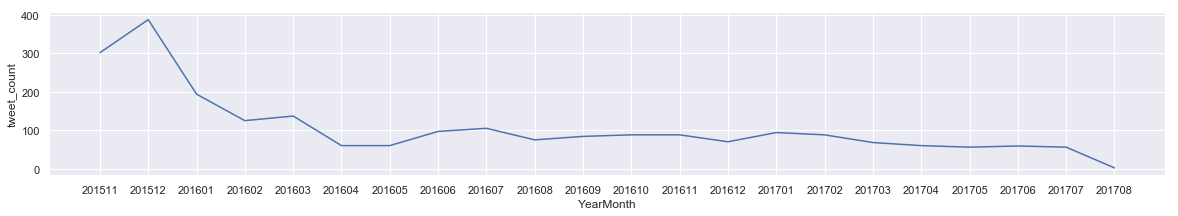

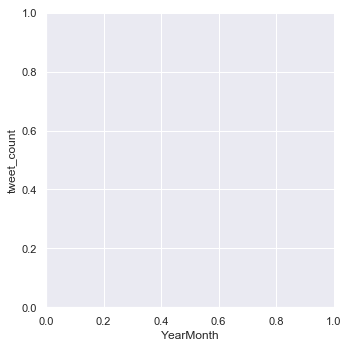

In [77]:
#Filter the necessary columns
df_tweet_archive_date = df_tweet_archive_clean[['tweet_id', 'timestamp']].copy()

#drop duplicates
df_tweet_archive_date_no_dup = df_tweet_archive_date.drop_duplicates()

#gather year, month, yearmonth information
df_tweet_archive_date_no_dup['Year']= df_tweet_archive_date_no_dup['timestamp'].apply(lambda x: x.year)
df_tweet_archive_date_no_dup['Month']= df_tweet_archive_date_no_dup['timestamp'].apply(lambda x: x.month)
df_tweet_archive_date_no_dup['YearMonth'] = df_tweet_archive_date_no_dup['timestamp'].map(lambda x: 100*x.year + x.month)

#get tweet count by group with 'Yearmonth'
df_tweets_by_month =  df_tweet_archive_date_no_dup.groupby(['YearMonth', 'Year', 'Month']).count().reset_index()[['YearMonth', 'Year', 'Month', 'tweet_id']]
df_tweets_by_month.rename(index=str, columns={'tweet_id':'tweet_count'}, inplace=True)
df_tweets_by_month['YearMonth'] = df_tweets_by_month['YearMonth'].astype('str')

#Plot the tweet count trend
sns.set()
f = plt.figure(figsize=(20,3))
ax = f.add_subplot(1, 1, 1)
sns.relplot(x="YearMonth", y="tweet_count", kind="line", data=df_tweets_by_month, ax=ax);


### Rating Insights

12.0    560
11.0    467
10.0    454
13.0    352
9.0     158
8.0     101
14.0     56
7.0      54
5.0      35
6.0      32
0.0      23
3.0      19
4.0      15
2.0      11
1.0       8
20.0      5
15.0      2
17.0      1
Name: rating_numerator, dtype: int64

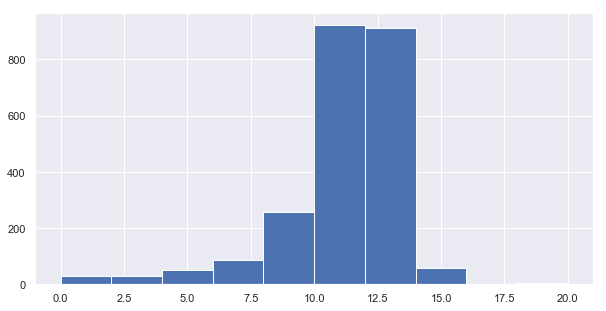

In [78]:
#group tweetid, rating to remove duplicates
df_rating_numerator_details =  df_tweet_archive_clean.groupby(['tweet_id', 'rating_numerator']).count() \
                        .reset_index()[['tweet_id', 'rating_numerator']]

#Plot the histogram of rating scores
plt.figure(figsize=(10,5))
df_rating_numerator_details.rating_numerator.hist();
df_rating_numerator_details.rating_numerator.value_counts()

#### Tweet Source Insight

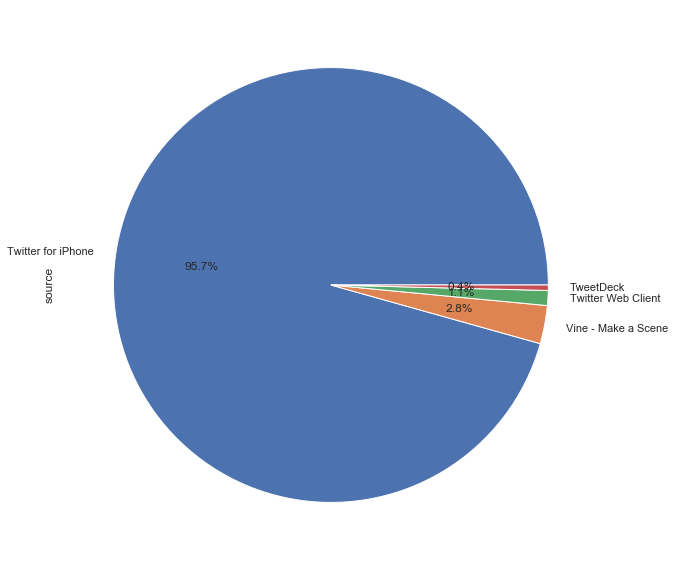

In [79]:
#plot the distributtion of Twitter Source
plt.figure(figsize=(10,10))
df_tweet_archive_clean.source.value_counts().plot(kind='pie', autopct='%.1f%%');

#### Predictor Conflicts

Let's Identify the conflicts between p1, p2, p3. i.e. Check if all the predictions are correctly, the image is a dog or not. Or if the p1, p2, p3 - some of them says its a dog or some says its not a dog 

In [80]:
df_pred_result = df_image_prediction_clean.groupby(['tweet_id', 'prediction_number']).sum() \
                        .reset_index()[['tweet_id', 'prediction_number', 'is_dog']]

df_pred_result = df_pred_result.groupby(['tweet_id']).sum().reset_index()
df_pred_overall_result = df_pred_result.is_dog.value_counts().reset_index()
df_pred_overall_result.rename(index=str, columns={'index':'pred_combined'}, inplace=True)

In [81]:
''' classifies whether the predictors are in conflict or non-conflict '''
def classify_conflict(dataframe=None):
    if dataframe['pred_combined'] == 3 or dataframe['pred_combined'] == 0:
        return 'Non-Conflict'
    else:
        return 'Conflict'

df_pred_overall_result['conflict_classification'] = df_pred_overall_result.apply(classify_conflict, axis=1)

In [82]:
df_conflict_result = df_pred_overall_result.groupby(['conflict_classification']).sum() \
                        .reset_index()[['conflict_classification', 'is_dog']]
df_conflict_result.rename(index=str, columns={'is_dog': 'count'})

,conflict_classification,count
0,Conflict,508
1,Non-Conflict,1567


#### Top 3 favorite dog stages

In [83]:
#Get top 3 favorite counts
top_3_favorites = df_tweet_archive_clean.favorite_count.sort_values(ascending=False).head(3).reset_index()
top_3_favorites.rename(index=str, columns={'index':'row_number'}, inplace=True)

In [84]:
#get top 3 favorite count's tweet id and dog stage
top_3_favorites.merge(df_tweet_archive_clean, how='inner', left_on='row_number', right_index=True)[['tweet_id','dog_stage', 'favorite_count_x']]

,tweet_id,dog_stage,favorite_count_x
0,744234799360020481,doggo,165032.0
1,822872901745569793,puppo,141106.0
2,807106840509214720,None,127731.0


In [85]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text= df_image_prediction_clean[df_image_prediction_clean.is_dog == 1]['predicted_breed'].values
text = np.append(text, df_tweet_archive_clean[~df_tweet_archive_clean.dog_stage.isnull()]['dog_stage'].values)

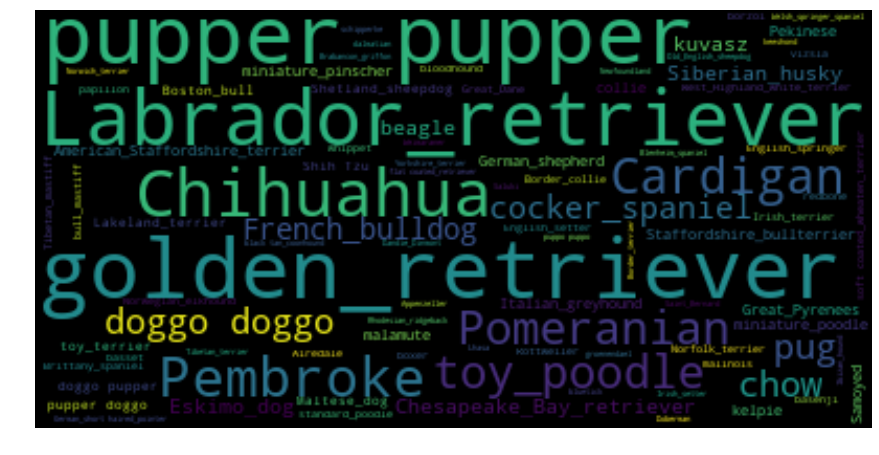

In [86]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(' '.join(text))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
